# Topic disaggregation

### Repeat the same process on data previously disaggregated according to the categories of the vote

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
from shapely.geometry import LineString
from matplotlib.lines import Line2D

In [2]:
import sys
sys.path.insert(0, '../local/bin')

In [3]:
def create_members_df(members, party_codes):
    temp_congress = members.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))                                                           # group by icpsr and aggregate the congress numbers into a list
    temp_party = members.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))                                                       # group by icpsr and aggregate the party codes into a list
    temp_congress = temp_congress.merge(temp_party)                                                                                                         # merge the two dataframes
    temp_congress['bioname'] = temp_congress['icpsr'].map(members[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])                            # insert the bioname based on the icpsr 
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(members[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])             # insert the state_abbrev based on the icpsr
    party_codes_dic = party_codes[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']                                             # create a dictionary for the party codes
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])                                              # insert the party name based on the party code
    return temp_congress

In [4]:
members = pd.read_csv('../dataset/HSall_members.csv')
party_codes = pd.read_csv('../dataset/HSall_parties.csv')

members_info = create_members_df(members, party_codes)

member_party_dict = members_info.set_index('icpsr')['party_name'].to_dict()		# member_id -> party_name

In [5]:
def create_edgelist_from_congress(congress, members_party_dict):
	edgelist = pd.DataFrame()

	for voteid in tqdm(set(congress['id'])):                 # iterate over all votes id (ids are unique for each vote)

		temp = congress[congress['id'] == voteid]            # select the rows where the vote id is equal to the current vote id            

		yy = temp[temp['vote']=='Yea']['icpsr']              # select the icpsr of the members that voted "Yea"
		nn = temp[temp['vote']=='Nay']['icpsr']                         

		y = itertools.combinations(yy, 2)                    # all possible combinations of 2 members that voted "Yea"
		n = itertools.combinations(nn, 2)                
		o = itertools.product(yy, nn)                        # cartesian product of the 2 series

		y = pd.DataFrame(y, columns = ['source', 'target'])  # create a dataframe from the combinations of "Yea" voters
		y['weight'] = 1                                      # add a column with the weight of the edge
		y['count'] = 1                                         

		n = pd.DataFrame(n, columns = ['source', 'target'])     
		n['weight'] = 1                                         
		n['count'] = 1                                          

		o = pd.DataFrame(o, columns = ['source', 'target'])     
		o['weight'] = -1                                     # same but the link is negative                    
		o['count'] = 1                                          

		edgelist = pd.concat([edgelist, y, n, o])
		edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count                  

	edgelist = pd.concat([edgelist, pd.DataFrame({
		'source': edgelist['target'],                        # new columns based on old columns: 
		'target': edgelist['source'],                        #   'newcolumn': dataframe['oldcolumn']
		'weight': edgelist['weight'],
		'count': edgelist['count']})])

	edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]                    # remove duplicates
	edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count
	edgelist['party'] = edgelist.apply(lambda row: 'in' if members_party_dict[row['source']] == members_party_dict[row['target']] else 'out', axis=1)   # create a column with the party of the edge

	map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()                                                                         # create a dictionary with the number of votes togheter for each pair of nodes                               

	edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
	edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

	return edgelist

In [6]:
congress_path = '../dataset/download_votes_merged/*'
congress_path_senate = '../dataset/download_votes_merged_senate/*'

In [7]:
# Initialize a weighted bipartite graph
G = nx.Graph()

# Iterate through each CSV file
for csv_file in tqdm(glob.glob(congress_path)):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each pair of Clausen and Peltzman categories
    counts = df.groupby(["Clausen", "Peltzman"]).size().reset_index(name="count")
    
    # Add edges to the graph with weights based on the counts
    for _, row in counts.iterrows():
        clausen_category = row["Clausen"]
        peltzman_category = row["Peltzman"]
        count = row["count"]
        
        G.add_node(clausen_category, bipartite=0)
        G.add_node(peltzman_category, bipartite=1)
        G.add_edge(clausen_category, peltzman_category, weight=count)

# Now you have a weighted bipartite graph (G) with edges representing the co-occurrences
# between Clausen and Peltzman categories and weights representing the number of occurrences.

  0%|          | 0/41 [00:00<?, ?it/s]

 78%|███████▊  | 32/41 [00:38<00:12,  1.37s/it]/tmp/ipykernel_10043/3165551236.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
100%|██████████| 41/41 [00:55<00:00,  1.35s/it]


In [8]:
print('Clausen categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0])
print('Number of Clausen categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]))

print('Peltzman categories: ', [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1])
print('Number of Peltzman categories: ', len([n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]))

Clausen categories:  ['Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare']
Number of Clausen categories:  6
Peltzman categories:  ['Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'Domestic Social Policy', 'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 'Budget General Interest', 'D. C.', 'Government Organization', 'Indian Affairs', 'Internal Organization']
Number of Peltzman categories:  13


In [9]:
clausen_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 0]
peltzman_cat_list = [n for n in G.nodes() if G.nodes[n]['bipartite'] == 1]

In [10]:
clausen_cat_dic = {x: re.sub(' ', '_', x) for x in clausen_cat_list}
peltzman_cat_dic = {x: re.sub(' ', '_', x) for x in peltzman_cat_list}

In [1]:
#execute all of the above

____________________________________________________

## Disaggregate the congresses and create proper datasets
This procedure takes time so <span style="color:red">skip the next cells if you already have the disaggregated datasets</span>

In [12]:
os.makedirs('../dataset/votes_house_clausen', exist_ok=True)
os.makedirs('../dataset/votes_senate_clausen', exist_ok=True)

os.makedirs('../dataset/votes_house_peltzman', exist_ok=True)
os.makedirs('../dataset/votes_senate_peltzman', exist_ok=True)

In [13]:
for clausen in clausen_cat_dic.values():
	os.makedirs('../dataset/votes_house_clausen/' + clausen, exist_ok=True)
	os.makedirs('../dataset/votes_senate_clausen/' + clausen, exist_ok=True)

for peltzman in peltzman_cat_dic.values():
	os.makedirs('../dataset/votes_house_peltzman/' + peltzman, exist_ok=True)
	os.makedirs('../dataset/votes_senate_peltzman/' + peltzman, exist_ok=True)

In [14]:
for csv in tqdm(glob.glob(congress_path)):
    n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

    df_congress = pd.read_csv(csv)

    for i in clausen_cat_dic.keys():
        filtered_df = df_congress[df_congress['Clausen'] == i]
        if not filtered_df.empty:
            filtered_df.to_csv('../dataset/votes_house_clausen/'+clausen_cat_dic[i]+'/congress_'+str(n_congress)+'.csv', index=False)

    for i in peltzman_cat_dic.keys():
        filtered_df = df_congress[df_congress['Peltzman'] == i]
        if not filtered_df.empty:
            filtered_df.to_csv('../dataset/votes_house_peltzman/'+peltzman_cat_dic[i]+'/congress_'+str(n_congress)+'.csv', index=False)

 78%|███████▊  | 32/41 [02:00<00:34,  3.84s/it]/tmp/ipykernel_867/1185449784.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_congress = pd.read_csv(csv)
100%|██████████| 41/41 [03:00<00:00,  4.39s/it]


In [15]:
for csv in tqdm(glob.glob(congress_path_senate)):
    n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

    df_congress = pd.read_csv(csv)

    for i in clausen_cat_dic.keys():
        filtered_df = df_congress[df_congress['Clausen'] == i]
        if not filtered_df.empty:
            filtered_df.to_csv('../dataset/votes_senate_clausen/'+clausen_cat_dic[i]+'/congress_'+str(n_congress)+'.csv', index=False)

    for i in peltzman_cat_dic.keys():
        filtered_df = df_congress[df_congress['Peltzman'] == i]
        if not filtered_df.empty:
            filtered_df.to_csv('../dataset/votes_senate_peltzman/'+peltzman_cat_dic[i]+'/congress_'+str(n_congress)+'.csv', index=False)

100%|██████████| 41/41 [00:35<00:00,  1.16it/s]


_________________________________________________________________________

## Create edgelists
This procedure takes time so <span style="color:red">skip the next cells if you already have the edgelists of the disaggregated datasets</span>

#### Create folders

In [16]:
os.makedirs('../dataset/edgelists/', exist_ok=True)

os.makedirs('../dataset/edgelists/votes_house_clausen_edges/', exist_ok=True)
os.makedirs('../dataset/edgelists/votes_house_peltzman_edges/', exist_ok=True)

os.makedirs('../dataset/edgelists/votes_senate_clausen_edges/', exist_ok=True)
os.makedirs('../dataset/edgelists/votes_senate_peltzman_edges/', exist_ok=True)

In [17]:
for clausen in clausen_cat_dic.values():
	os.makedirs('../dataset/edgelists/votes_house_clausen_edges/'+clausen, exist_ok=True)
	os.makedirs('../dataset/edgelists/votes_senate_clausen_edges/'+clausen, exist_ok=True)

for peltzman in peltzman_cat_dic.values():
	os.makedirs('../dataset/edgelists/votes_house_peltzman_edges/'+peltzman, exist_ok=True)
	os.makedirs('../dataset/edgelists/votes_senate_peltzman_edges/'+peltzman, exist_ok=True)

#### Create house of representatives edgelists

In [ ]:
for clausen in clausen_cat_dic.values():
	for csv in glob.glob('../dataset/votes_house_clausen/'+clausen+'/*'):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		df_congress = pd.read_csv(csv)
		edgelist = create_edgelist_from_congress(df_congress, member_party_dict)
		edgelist.to_csv('../dataset/edgelists/votes_house_clausen_edges/'+clausen+'/congress_'+str(n_congress)+'.csv', index=False)

In [ ]:
for peltzman in peltzman_cat_dic.values():
	for csv in glob.glob('../dataset/votes_house_peltzman/'+peltzman+'/*'):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		df_congress = pd.read_csv(csv)
		edgelist = create_edgelist_from_congress(df_congress, member_party_dict)
		edgelist.to_csv('../dataset/edgelists/votes_house_peltzman_edges/'+peltzman+'/congress_'+str(n_congress)+'.csv', index=False)

#### Create senate edgelist

In [ ]:
for clausen in clausen_cat_dic.values():
	for csv in glob.glob('../dataset/votes_senate_clausen/'+clausen+'/*'):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		df_congress = pd.read_csv(csv)
		edgelist = create_edgelist_from_congress(df_congress, member_party_dict)
		edgelist.to_csv('../dataset/edgelists/votes_senate_clausen_edges/'+clausen+'/congress_'+str(n_congress)+'.csv', index=False)

In [ ]:
for peltzman in peltzman_cat_dic.values():
	for csv in glob.glob('../dataset/votes_senate_peltzman/'+peltzman+'/*'):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		df_congress = pd.read_csv(csv)
		edgelist = create_edgelist_from_congress(df_congress, member_party_dict)
		edgelist.to_csv('../dataset/edgelists/votes_senate_peltzman_edges/'+peltzman+'/congress_'+str(n_congress)+'.csv', index=False)

Create the 79th house edgelist (Category "Civil_Liberties") since it appears to be problematic

In [3]:
import os
import pandas as pd

In [12]:
# create the edgelist of the 79th congress in clausen category "Civil_Liberties"
df = pd.read_csv('../dataset/votes_house_clausen/Civil_Liberties/congress_79.csv')
edgelist = create_edgelist_from_congress(df, member_party_dict)
edgelist.to_csv('../dataset/edgelists/votes_house_clausen_edges/Civil_Liberties/congress_79.csv', index=False)

 50%|█████     | 2/4 [00:00<00:00, 10.08it/s]

100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


_______________________________________________________________________________________

## Compute and create thresholds files for the edgelists

In [63]:
def check_singular_covariance_matrix(df):
	relevant_columns = ['weight', 'perc']
	subset_df = df[relevant_columns]

	# Calculate the covariance matrix
	covariance_matrix = np.cov(subset_df, rowvar=False)

	# Check if the determinant is zero (indicating a singular covariance matrix)
	is_singular = np.linalg.det(covariance_matrix) <= 1e-3

	if is_singular: return True
	else: return False

In [57]:
def compute_threshold_intersx(df, weight):	#df is the edgelist, weight is the weight of the edge

	def _midpoint(p1, p2):
		return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

	def line_intersection(in_party, out_party, intersect_points):
		index_in = np.argmax(in_party[1])
		index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
		point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
		point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
		midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
		index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
		return intersect_points[index_closer][0]

	x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
	x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
	bw = len(x0)**(-1./(2+4))
	kde0 = gaussian_kde(x0, bw_method=bw)
	bw = len(x1)**(-1./(2+4))
	kde1 = gaussian_kde(x1, bw_method=bw)

	xmin = min(x0.min(), x1.min())
	xmax = max(x0.max(), x1.max())
	dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
	xmin -= dx
	xmax += dx

	x = np.linspace(xmin, xmax, 500)
	kde0_x = kde0(x)
	kde1_x = kde1(x)
	inters_x = np.minimum(kde0_x, kde1_x)

	idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
	threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
	area_inters_x = np.trapz(inters_x, x)

	return threshold, area_inters_x

In [58]:
main_dir_name = '../dataset/thresholds/'

os.makedirs(main_dir_name, exist_ok=True)

os.makedirs(main_dir_name + 'house_clausen_thresholds/', exist_ok=True)
os.makedirs(main_dir_name + 'house_peltzman_thresholds/', exist_ok=True)

os.makedirs(main_dir_name + 'senate_clausen_thresholds/', exist_ok=True)
os.makedirs(main_dir_name + 'senate_peltzman_thresholds/', exist_ok=True)

In [59]:
for clausen in clausen_cat_dic.values():
	os.makedirs(main_dir_name + 'house_clausen_thresholds/' + clausen, exist_ok=True)
	os.makedirs(main_dir_name + 'senate_clausen_thresholds/' + clausen, exist_ok=True)

for peltzman in peltzman_cat_dic.values():
	os.makedirs(main_dir_name + 'house_peltzman_thresholds/' + peltzman, exist_ok=True)
	os.makedirs(main_dir_name + 'senate_peltzman_thresholds/' + peltzman, exist_ok=True)

In [22]:
for clausen in clausen_cat_dic.values():
    for csv in glob.glob('../dataset/edgelists/votes_house_clausen_edges/' + clausen + '/*'):
        n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
        df_congress = pd.read_csv(csv)

        # Check if the covariance matrix is singular
        is_singular = check_singular_covariance_matrix(df_congress)
        if is_singular: continue

        threshold_pos, area_pos = compute_threshold_intersx(df_congress, 1)
        threshold_neg, area_neg = compute_threshold_intersx(df_congress, -1)

        # Create a DataFrame with the desired columns and header
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg]
        })

        # Save the DataFrame to CSV with the specified filename and header
        output_filename = f'{n_congress}_dic_thresholds_norm.csv'
        df_output.to_csv('../dataset/thresholds/house_clausen_thresholds/' + clausen + '/' + output_filename, header=True, index=False)
		

In [ ]:
for clausen in clausen_cat_dic.values():
    for csv in glob.glob('../dataset/edgelists/votes_senate_clausen_edges/' + clausen + '/*'):
        n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
        df_congress = pd.read_csv(csv)

        # Check if the covariance matrix is singular
        is_singular = check_singular_covariance_matrix(df_congress)
        if is_singular: continue

        threshold_pos, area_pos = compute_threshold_intersx(df_congress, 1)
        threshold_neg, area_neg = compute_threshold_intersx(df_congress, -1)

        # Create a DataFrame with the desired columns and header
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg]
        })

        # Save the DataFrame to CSV with the specified filename and header
        output_filename = f'{n_congress}_dic_thresholds_norm.csv'
        df_output.to_csv('../dataset/thresholds/senate_clausen_thresholds/' + clausen + '/' + output_filename, header=True, index=False)

In [64]:
for peltzman in peltzman_cat_dic.values():
    for csv in glob.glob('../dataset/edgelists/votes_house_peltzman_edges/' + peltzman + '/*'):
        n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
        print(str(peltzman) + '-' + str(n_congress))
        df_congress = pd.read_csv(csv)

        # Check if the covariance matrix is singular
        is_singular = check_singular_covariance_matrix(df_congress)
        if is_singular: 
            continue

        threshold_pos, area_pos = compute_threshold_intersx(df_congress, 1)
        threshold_neg, area_neg = compute_threshold_intersx(df_congress, -1)

        # Create a DataFrame with the desired columns and header
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg]
        })

        # Save the DataFrame to CSV with the specified filename and header
        output_filename = f'{n_congress}_dic_thresholds_norm.csv'
        df_output.to_csv('../dataset/thresholds/house_peltzman_thresholds/' + peltzman + '/' + output_filename, header=True, index=False)

Budget_Special_Interest-86
Budget_Special_Interest-80
Budget_Special_Interest-90
Budget_Special_Interest-102
Budget_Special_Interest-101
Budget_Special_Interest-99
Budget_Special_Interest-83
Budget_Special_Interest-92
Budget_Special_Interest-107
Budget_Special_Interest-103
Budget_Special_Interest-78
Budget_Special_Interest-87
Budget_Special_Interest-110
Budget_Special_Interest-100
Budget_Special_Interest-95
Budget_Special_Interest-84
Budget_Special_Interest-85
Budget_Special_Interest-98
Budget_Special_Interest-105
Budget_Special_Interest-106
Budget_Special_Interest-91
Budget_Special_Interest-93
Budget_Special_Interest-112
Budget_Special_Interest-109
Budget_Special_Interest-94
Budget_Special_Interest-96
Budget_Special_Interest-89
Budget_Special_Interest-111
Budget_Special_Interest-88
Budget_Special_Interest-108
Budget_Special_Interest-79
Budget_Special_Interest-113
Budget_Special_Interest-82
Budget_Special_Interest-77
Budget_Special_Interest-104
Budget_Special_Interest-97
Budget_Special

In [49]:
determinants = {}

for csv in glob.glob('../dataset/edgelists/votes_house_peltzman_edges/' + 'D._C./' + '*.csv'):
	# check the covariance matrix of "weight" and "perc" in the congress_107 (peltzman category = D._C.)
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
	df_congress = pd.read_csv(csv)

	relevant_columns = ['weight', 'perc']
	subset_df = df_congress[relevant_columns]

	# Calculate the covariance matrix
	covariance_matrix = np.cov(subset_df, rowvar=False)

	# Check if the determinant is zero (indicating a singular covariance matrix)
	det = np.linalg.det(covariance_matrix)
	determinants[n_congress] = det




0.07905203381705904

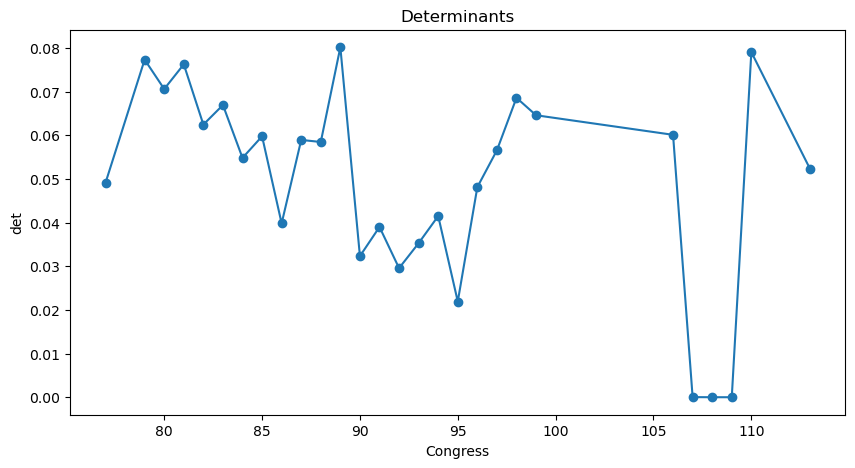

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(sorted(determinants.keys()), [determinants[x] for x in sorted(determinants.keys())], 'o-')
plt.xlabel('Congress')
plt.ylabel('det')
plt.title('Determinants')

plt.show()

In [19]:
df_congress

,source,target,weight,count,party,votes_togheter,perc
0,2605,10713,1,2,in,2,1.0
1,2605,10757,1,2,in,2,1.0
2,2605,12036,1,2,in,2,1.0
3,2605,12041,1,2,out,2,1.0
4,2605,13035,1,2,in,2,1.0
...,...,...,...,...,...,...,...
88820,39316,99342,1,2,in,2,1.0
88821,39316,99767,1,2,out,2,1.0
88822,94679,99342,1,2,in,2,1.0
88823,94679,99767,1,2,out,2,1.0


In [ ]:
for peltzman in peltzman_cat_dic.values():
    for csv in glob.glob('../dataset/edgelists/votes_senate_peltzman_edges/' + peltzman + '/*'):
        n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
        df_congress = pd.read_csv(csv)

        # Check if the covariance matrix is singular
        is_singular = check_singular_covariance_matrix(df_congress)
        if is_singular: continue

        threshold_pos, area_pos = compute_threshold_intersx(df_congress, 1)
        threshold_neg, area_neg = compute_threshold_intersx(df_congress, -1)

        # Create a DataFrame with the desired columns and header
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg]
        })

        # Save the DataFrame to CSV with the specified filename and header
        output_filename = f'{n_congress}_dic_thresholds_norm.csv'
        df_output.to_csv('../dataset/thresholds/senate_peltzman_thresholds/' + peltzman + '/' + output_filename, header=True, index=False)

In [ ]:
# compute and print thresholds and area for the 82nd congress in clausen category "Civil_Liberties"
df = pd.read_csv('../dataset/edgelists/votes_house_clausen_edges/Civil_Liberties/congress_82.csv')
threshold_pos, area_pos = compute_threshold_intersx(df, 1)
threshold_neg, area_neg = compute_threshold_intersx(df, -1)
print(threshold_pos, area_pos, threshold_neg, area_neg)

In [13]:
from scipy.stats import gaussian_kde

### Try the procedure on a single congress
The execution of the following 3 cells is unnecessary, it allows to test the procedure on a single congress

In [15]:
def plot_kde(df, weight):
    
    def _midpoint(p1, p2):
        return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

    def line_intersection(in_party, out_party, intersect_points):
        index_in = np.argmax(in_party[1])
        index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
        point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
        point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
        midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
        index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
        return intersect_points[index_closer][0]
        
    x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
    x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
    bw = len(x0)**(-1./(2+4))
    kde0 = gaussian_kde(x0, bw_method=bw)
    bw = len(x1)**(-1./(2+4))
    kde1 = gaussian_kde(x1, bw_method=bw)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
    threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(17, 13))
    fig1.set_size_inches(20, 12)

    ax1.plot(x, kde0_x, color='b', label='intra-party')
    ax1.fill_between(x, kde0_x, 0, color='b', alpha=0.2)

    ax1.plot(x, kde1_x, color='orange', label='inter-party')
    ax1.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)

    ax1.plot(x, inters_x, color='tomato')
    ax1.fill_between(x, inters_x, 0, facecolor='none', edgecolor='tomato', label='intersection', alpha=0.5, hatch='xx')
    
    ax1.axvspan(threshold-0.0025, threshold+0.0025,color='tomato', alpha=0.7, zorder=10)
    ax1.text(threshold-.25, .93, 'threshold: '+str(round(threshold, 2)), fontsize=23,transform=ax1.transAxes)
    
    area_inters_x = np.trapz(inters_x, x)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels[2] += f': {area_inters_x * 100:.1f} %'
    ax1.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel('Edges percentage', fontsize=25)
    plt.ylabel('Density', fontsize=25)
    title = "Positive edges" if weight == 1 else "Negative edges"
    c_title = "g" if weight == 1 else "r"
    plt.title(title, fontsize=31, pad=10, ha='left', x=.0, c=c_title)

    legend1 = plt.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='upper center', bbox_to_anchor=(0.4, 1.08), frameon=False, ncol=2, fontsize=23)
    plt.legend([handles[2]], [labels[2]], loc='upper center', bbox_to_anchor=(0.84, 1.08), frameon=False, ncol=1, fontsize=23)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.grid(axis='y')
    
    ax1.set_xlim([-0.07, 1.1])

    plt.show()

In [16]:
test_category_set = 'clausen'		# 'clausen' or 'peltzman'

########################################################################################################################################################################
# 	Clausen categories: 	'Agriculture', 'Civil Liberties', 'Foreign and Defense Policy', 'Government Management', 'Miscellaneous Policy', 'Social Welfare'		   #
# 	Peltzman categories:	'Budget Special Interest', 'Regulation General Interest', 'Regulation Special Interest', 'Domestic Social Policy', 						   #
# 							'Defense Policy Budget', 'Defense Policy Resolutions', 'Foreign Policy Budget', 'Foreign Policy Resolutions', 							   #
# 							'Budget General Interest', 'D. C.', 'Government Organization', 'Indian Affairs', 'Internal Organization'								   #
########################################################################################################################################################################
test_category = 'Civil_Liberties'

test_chamber = 'house'				# 'house' or 'senate
test_n_congress = 77				# from 77 to 117

test_congress = '../dataset/votes_' + test_chamber + '_' + test_category_set + '/' + test_category + '/congress_' + str(test_n_congress) + '.csv'
test_edgelist = '../dataset/edgelists/votes_' + test_chamber + '_' + test_category_set + '_edges/' + test_category + '/congress_' + str(test_n_congress) + '.csv'

df_test_congress = pd.read_csv(test_congress)
df_test_edges = pd.read_csv(test_edgelist)

define a function that check the collinearity of witght and perc

In [ ]:
plot_kde(df_test_edges, 1)

In [20]:
threshold_pos, inters_x = compute_threshold_intersx(df_test_edges, 1)
threshold_neg, _ = compute_threshold_intersx(df_test_edges, -1)
print('threshold_pos: ', threshold_pos)
print('threshold_neg: ', threshold_neg)
print('intersection area: ', inters_x)

threshold_pos:  0.7176170522863909
threshold_neg:  0.2879509018036072
intersection area:  0.03750795352594417


In [80]:
for clausen in clausen_cat_dic.values():
	for csv in glob.glob('../dataset/edgelists/votes_house_clausen_edges/'+clausen+'/*'):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))
		df_congress = pd.read_csv(csv)

___________________________________________________________________________________________________________

## Save all the possible plots in a proper folder
<span style="color:red">There are many memory issues here... do not create plots with for-cycles as for now</span>

In [28]:
def plot_save_kde(df, weight, main_dir_name, category_set, category, chamber, n_congress):

    def _midpoint(p1, p2):
        return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

    def line_intersection(in_party, out_party, intersect_points):
        index_in = np.argmax(in_party[1])
        index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
        point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
        point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
        midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
        index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
        return intersect_points[index_closer][0]
        
    label = "agree" if weight == 1 else "disagree"

    x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
    x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
    bw = len(x0)**(-1./(2+4))
    kde0 = gaussian_kde(x0, bw_method=bw)
    bw = len(x1)**(-1./(2+4))
    kde1 = gaussian_kde(x1, bw_method=bw)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
    threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(17, 13))
    fig1.set_size_inches(20, 12)

    ax1.plot(x, kde0_x, color='b', label='intra-party')
    ax1.fill_between(x, kde0_x, 0, color='b', alpha=0.2)

    ax1.plot(x, kde1_x, color='orange', label='inter-party')
    ax1.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)

    ax1.plot(x, inters_x, color='tomato')
    ax1.fill_between(x, inters_x, 0, facecolor='none', edgecolor='tomato', label='intersection', alpha=0.5, hatch='xx')
    
    ax1.axvspan(threshold-0.0025, threshold+0.0025,color='tomato', alpha=0.7, zorder=10)
    ax1.text(threshold-.25, .93, 'threshold: '+str(round(threshold, 2)), fontsize=23,transform=ax1.transAxes)
    
    area_inters_x = np.trapz(inters_x, x)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels[2] += f': {area_inters_x * 100:.1f} %'
    ax1.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel('Edges percentage', fontsize=25)
    plt.ylabel('Density', fontsize=25)
    title = "Positive edges" if weight == 1 else "Negative edges"
    c_title = "g" if weight == 1 else "r"
    plt.title(title, fontsize=31, pad=10, ha='left', x=.0, c=c_title)

    legend1 = plt.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='upper center', bbox_to_anchor=(0.4, 1.08), frameon=False, ncol=2, fontsize=23)
    plt.legend([handles[2]], [labels[2]], loc='upper center', bbox_to_anchor=(0.84, 1.08), frameon=False, ncol=1, fontsize=23)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.grid(axis='y')
    
    plt.ioff()
    
    ax1.set_xlim([-0.07, 1.1])
    
    plt.savefig(main_dir_name + chamber + '_' + category_set + '_kdeplots/' + category + '/congress_' + str(n_congress) + '_' + label + '.png', dpi=300)

    plt.close(fig1)

In [22]:
main_dir_name = '../dataset/kdeplots/'

os.makedirs(main_dir_name, exist_ok=True)

os.makedirs(main_dir_name + 'house_clausen_kdeplots/', exist_ok=True)
os.makedirs(main_dir_name + 'house_peltzman_kdeplots/', exist_ok=True)

os.makedirs(main_dir_name + 'senate_clausen_kdeplots/', exist_ok=True)
os.makedirs(main_dir_name + 'senate_peltzman_kdeplots/', exist_ok=True)

In [23]:
for clausen in clausen_cat_dic.values():
	os.makedirs(main_dir_name + 'house_clausen_kdeplots/' + clausen, exist_ok=True)
	os.makedirs(main_dir_name + 'senate_clausen_kdeplots/' + clausen, exist_ok=True)

for peltzman in peltzman_cat_dic.values():
	os.makedirs(main_dir_name + 'house_peltzman_kdeplots/' + peltzman, exist_ok=True)
	os.makedirs(main_dir_name + 'senate_peltzman_kdeplots/' + peltzman, exist_ok=True)

Main idea was to produce GIFs with the evolution of the kde plots